In [1]:
from __future__ import print_function
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re
import pandas as pd
import pickle
import threading
import sys

class FOMC (object):
    '''
    A convenient class for extracting meeting minutes from the FOMC website
    Example Usage:  
        fomc = FOMC()
        df = fomc.get_statements()
        fomc.pickle("./df_minutes.pickle")
    '''

    def __init__(self, base_url='https://www.federalreserve.gov', 
                 calendar_url='https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm',
                 historical_date = 2014,
                 verbose = True,
                 max_threads = 10):

        self.base_url = base_url
        self.calendar_url = calendar_url
        self.df = None
        self.links = None
        self.dates = None
        self.articles = None
        self.verbose = verbose
        self.HISTORICAL_DATE = historical_date
        self.MAX_THREADS = max_threads
    

    def _get_links(self, from_year):
        '''
        private function that sets all the links for the FOMC meetings from the giving from_year
        to the current most recent year
        '''
        if self.verbose:
            print("Getting links...")
        self.links = []
        fomc_meetings_socket = urlopen(self.calendar_url)
        soup = BeautifulSoup(fomc_meetings_socket, 'html.parser')
        
        statements = soup.find_all('a', href=re.compile('^/monetarypolicy/fomcminutes\d{8}.htm'))
        self.links = [statement.attrs['href'] for statement in statements] 
        print(self.links)
        
        if from_year <= self.HISTORICAL_DATE:   
            for year in range(from_year, self.HISTORICAL_DATE + 1):
                fomc_yearly_url = self.base_url + '/monetarypolicy/fomchistorical' + str(year) + '.htm'
                print(fomc_yearly_url)
                fomc_yearly_socket = urlopen(fomc_yearly_url)
                soup_yearly = BeautifulSoup(fomc_yearly_socket, 'html.parser')
                statements_historical = soup_yearly.findAll('a', text = 'Statement')
                for statement_historical in statements_historical:
                    self.links.append(statement_historical.attrs['href'])
        print(self.links)

    def _date_from_link(self, link):
        date = re.findall('[0-9]{8}', link)[0]
        if date[4] == '0':
            date = "{}/{}/{}".format(date[:4], date[5:6], date[6:])
        else:
            date = "{}/{}/{}".format(date[:4], date[4:6], date[6:])
        return date


    def _add_article(self, link, index=None):
        '''
        adds the related article for 1 link into the instance variable
        index is the index in the article to add to. Due to concurrent
        prcessing, we need to make sure the articles are stored in the
        right order
        '''
        if self.verbose:
            sys.stdout.write(".")
            sys.stdout.flush()

        # date of the article content
        self.dates.append(self._date_from_link(link))
        statement_socket = urlopen(self.base_url + link)
        statement = BeautifulSoup(statement_socket, 'html.parser')
        paragraphs = statement.findAll('p')
        self.articles[index]= "\n\n".join([paragraph.get_text().strip() for paragraph in paragraphs])


    def _get_articles_multi_threaded(self):
        '''
        gets all articles using multi-threading
        '''
        if self.verbose:
            print("Getting articles - Multi-threaded...")

        self.dates, self.articles = [], ['']*len(self.links)
        jobs = []
        # initiate and start threads:
        index = 0
        while index < len(self.links):
            if len(jobs) < self.MAX_THREADS:
                t = threading.Thread(target=self._add_article, args=(self.links[index],index,))
                jobs.append(t)
                t.start()
                index += 1
            else:    # wait for threads to complete and join them back into the main thread
                t = jobs.pop(0)
                t.join()
        for t in jobs:
            t.join()

        for row in range(len(self.articles)):
            self.articles[row] = self.articles[row].strip()


    def get_statements(self, from_year=2015):
        '''
        Returns a Pandas DataFrame of meeting minutes with the date as the index
        uses a date range of from_year to the most current
        Input from_year is ignored if it is within the last 5 years as this is meant for 
        parsing much older years
        '''
        self._get_links(from_year)
        print("There are", len(self.links), 'statements')
        self._get_articles_multi_threaded()

        self.df = pd.DataFrame(self.articles, index = pd.to_datetime(self.dates)).sort_index()
        self.df.columns = ['statements']
        return self.df


    def pick_df(self, filename="../data/minutes.pickle"):
        if filename:
            if self.verbose:
                print("Writing to", filename)        
            with open(filename, "wb") as output_file:
                    pickle.dump(self.df, output_file)

if __name__ == '__main__':
    #Example Usage
    fomc = FOMC()
    d = fomc.get_statements()

Getting links...
['/monetarypolicy/fomcminutes20190130.htm', '/monetarypolicy/fomcminutes20180131.htm', '/monetarypolicy/fomcminutes20180321.htm', '/monetarypolicy/fomcminutes20180502.htm', '/monetarypolicy/fomcminutes20180613.htm', '/monetarypolicy/fomcminutes20180801.htm', '/monetarypolicy/fomcminutes20180926.htm', '/monetarypolicy/fomcminutes20181108.htm', '/monetarypolicy/fomcminutes20181219.htm', '/monetarypolicy/fomcminutes20170201.htm', '/monetarypolicy/fomcminutes20170315.htm', '/monetarypolicy/fomcminutes20170503.htm', '/monetarypolicy/fomcminutes20170614.htm', '/monetarypolicy/fomcminutes20170726.htm', '/monetarypolicy/fomcminutes20170920.htm', '/monetarypolicy/fomcminutes20171101.htm', '/monetarypolicy/fomcminutes20171213.htm', '/monetarypolicy/fomcminutes20160127.htm', '/monetarypolicy/fomcminutes20160316.htm', '/monetarypolicy/fomcminutes20160427.htm', '/monetarypolicy/fomcminutes20160615.htm', '/monetarypolicy/fomcminutes20160727.htm', '/monetarypolicy/fomcminutes20160921

In [0]:
d.to_csv('fomc.csv', sep=',', encoding = 'utf-8')

In [3]:
!pip install contractions

In [0]:
import contractions

df = d.copy()
df['statements'] = df['statements'].apply(lambda x: x.replace('\n', ' '))
df['statements'] = df['statements'].apply(lambda x: contractions.fix(x))
df['statements'] = df['statements'].apply(lambda x: x.lower())

In [0]:
#remove numbers and single characters

df['statements'] = df['statements'].apply(lambda x: ' '.join(re.sub(r"[^a-zA-z]+"," ",x).split()))
df['statements'] = df['statements'].apply(lambda x: ' '.join(re.sub(r"\b[a-zA-Z]\b", " ", x).split()))

In [0]:
#Remove punctuations
df['statements'] = df['statements'].str.replace('[^\w\s]','')

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
#Remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['statements'] = df['statements'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [9]:
#Lemmatize the text
nltk.download('wordnet')
nltk.download('punkt')

#POS tagging
nltk.download('averaged_perceptron_tagger')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
  """Map POS tag to first character lemmatize() accepts"""
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

  return tag_dict.get(tag, wordnet.NOUN)

df['statements'] = df['statements'].apply(lambda x: " ".join([ lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(x)]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:
from collections import Counter
import itertools

import nltk
import math
import re
import numpy as np
from scipy import sparse
from scipy.sparse import linalg 
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
#unigrams

tok2indx = dict()
unigram_counts = Counter()
statements = df['statements'].tolist()

for ii, statement in enumerate(statements):
    state = statement.split()
    if ii % 20000 == 0:
        print(f'finished {ii/len(statements):.2%} of headlines')
    for token in state:
        unigram_counts[token] += 1
        if token not in tok2indx:
            tok2indx[token] = len(tok2indx)
indx2tok = {indx:tok for tok,indx in tok2indx.items()}
print('done')
print('vocabulary size: {}'.format(len(unigram_counts)))
print('most common: {}'.format(unigram_counts.most_common(10)))

finished 0.00% of headlines
done
vocabulary size: 3907
most common: [('market', 3353), ('rate', 3347), ('inflation', 3168), ('committee', 3103), ('federal', 2513), ('participant', 2299), ('economic', 2087), ('policy', 2015), ('price', 1689), ('increase', 1663)]


In [12]:
#Skipgrams

back_window = 2
front_window = 2
skipgram_counts = Counter()
for inum, statement in enumerate(statements):
    state = statement.split()
    for ifw, fw in enumerate(state):
        icw_min = max(0, ifw - back_window)
        icw_max = min(len(state) - 1, ifw + front_window)
        icws = [ii for ii in range(icw_min, icw_max + 1) if ii != ifw]
        for icw in icws:
            skipgram = (state[ifw], state[icw])
            skipgram_counts[skipgram] += 1    
    if inum % 20000 == 0:
        print(f'finished {inum/len(statements):.2%} of statements')
        
print('done')

finished 0.00% of statements
done


In [13]:
print('number of skipgrams: {}'.format(len(skipgram_counts)))
print('most common: {}'.format(skipgram_counts.most_common(10)))

number of skipgrams: 213212
most common: [(('federal', 'fund'), 1154), (('fund', 'federal'), 1154), (('federal', 'rate'), 1151), (('rate', 'federal'), 1151), (('board', 'governor'), 1143), (('governor', 'board'), 1143), (('fund', 'rate'), 1106), (('rate', 'fund'), 1106), (('labor', 'market'), 1094), (('market', 'labor'), 1094)]


In [14]:
#Word-Word Count Matrix

row_indxs = []
col_indxs = []
data_values = []
ii = 0

for (tok1, tok2), sg_count in skipgram_counts.items():
  ii += 1
  if ii%100000 == 0:
    print(f'finished {ii/len(skipgram_counts):.2%} of skipgrams')
    
  tok1_indx = tok2indx[tok1]
  tok2_indx = tok2indx[tok2]
  
  row_indxs.append(tok1_indx)
  col_indxs.append(tok2_indx)
  data_values.append(sg_count)
  
wwcnt_matrix = sparse.csr_matrix((data_values, (row_indxs, col_indxs)))
  

finished 46.90% of skipgrams
finished 93.80% of skipgrams


In [0]:
#Word Similarity with Sparse Count Matrices

def ww_sim(word, mat, topn=10):
  """Calculate topn most similar words to word"""
  indx = tok2indx[word]
  if isinstance(mat, sparse.csr_matrix):
    v1 = mat.getrow(indx)
  else:
    v1 = mat[indx:indx+1, :]
    
  sims = cosine_similarity(mat, v1).flatten()
  sindxs = np.argsort(-sims)
  sim_word_scores = [(indx2tok[sindx], sims[sindx]) for sindx in sindxs[0:topn]]
  
  return sim_word_scores

In [16]:
#Pointwise Mutual Information Matrices

num_skipgrams = wwcnt_matrix.sum()
assert(sum(skipgram_counts.values())==num_skipgrams)

# for creating sparce matrices
row_indxs = []
col_indxs = []

pmi_dat_values = []
ppmi_dat_values = []
spmi_dat_values = []
sppmi_dat_values = []

# smoothing
alpha = 0.75
nca_denom = np.sum(np.array(wwcnt_matrix.sum(axis=0)).flatten()**alpha)
sum_over_words = np.array(wwcnt_matrix.sum(axis=0)).flatten()
sum_over_words_alpha = sum_over_words**alpha
sum_over_contexts = np.array(wwcnt_matrix.sum(axis=1)).flatten()

ii = 0
for (tok1, tok2), sg_count in skipgram_counts.items():
    ii += 1
    if ii % 1000000 == 0:
        print(f'finished {ii/len(skipgram_counts):.2%} of skipgrams')
    tok1_indx = tok2indx[tok1]
    tok2_indx = tok2indx[tok2]
    
    nwc = sg_count
    Pwc = nwc / num_skipgrams
    nw = sum_over_contexts[tok1_indx]
    Pw = nw / num_skipgrams
    nc = sum_over_words[tok2_indx]
    Pc = nc / num_skipgrams
    
    nca = sum_over_words_alpha[tok2_indx]
    Pca = nca / nca_denom
    
    pmi = np.log2(Pwc/(Pw*Pc))
    ppmi = max(pmi, 0)
    
    spmi = np.log2(Pwc/(Pw*Pca))
    sppmi = max(spmi, 0)
    
    row_indxs.append(tok1_indx)
    col_indxs.append(tok2_indx)
    pmi_dat_values.append(pmi)
    ppmi_dat_values.append(ppmi)
    spmi_dat_values.append(spmi)
    sppmi_dat_values.append(sppmi)
        
pmi_mat = sparse.csr_matrix((pmi_dat_values, (row_indxs, col_indxs)))
ppmi_mat = sparse.csr_matrix((ppmi_dat_values, (row_indxs, col_indxs)))
spmi_mat = sparse.csr_matrix((spmi_dat_values, (row_indxs, col_indxs)))
sppmi_mat = sparse.csr_matrix((sppmi_dat_values, (row_indxs, col_indxs)))

print('done')

done


In [17]:
#Word Similarity with Sparse PMI Matrices

ww_sim('rise', ppmi_mat)

[('rise', 1.0000000000000007),
 ('increase', 0.2898179481171413),
 ('fell', 0.28980835909985947),
 ('decline', 0.2772229063501382),
 ('move', 0.2745317106890779),
 ('expand', 0.2654722389469449),
 ('grow', 0.2588835512080484),
 ('risen', 0.2521566641412171),
 ('decrease', 0.24256289264322228),
 ('net', 0.239755433590515)]

In [18]:
ww_sim('rise', sppmi_mat)

[('rise', 0.9999999999999997),
 ('increase', 0.36048308535480017),
 ('expand', 0.3342724938114509),
 ('decline', 0.33049312709763157),
 ('fell', 0.32551682900820506),
 ('move', 0.3190846637508397),
 ('grow', 0.3189187284339197),
 ('risen', 0.3157696450293808),
 ('decrease', 0.306837431456608),
 ('edge', 0.2885147754839251)]

In [19]:
ww_sim('fell', sppmi_mat)

[('fell', 0.9999999999999996),
 ('sharply', 0.39048542205500486),
 ('decline', 0.3292086186984769),
 ('decrease', 0.32687744399038393),
 ('rise', 0.32551682900820506),
 ('widen', 0.31367080840073686),
 ('move', 0.28898464177727257),
 ('drop', 0.27087355541690394),
 ('narrow', 0.268178538318249),
 ('notably', 0.26131576159522474)]

In [0]:
#Singular Value Decomposition
pmi_use = sppmi_mat
embedding_size = 300
uu, ss, vv = linalg.svds(pmi_use, embedding_size)

In [21]:
print('vocab size: {}'.format(len(unigram_counts)))
print('embedding size: {}'.format(embedding_size))
print('uu.shape: {}'.format(uu.shape))
print('ss.shape: {}'.format(ss.shape))
print('vv.shape: {}'.format(vv.shape))

vocab size: 3907
embedding size: 300
uu.shape: (3907, 300)
ss.shape: (300,)
vv.shape: (300, 3907)


In [0]:
unorm = uu / np.sqrt(np.sum(uu*uu, axis=1, keepdims=True))
vnorm = vv / np.sqrt(np.sum(vv*vv, axis=0, keepdims=True))
sd = np.diag(ss)
word_vecs = np.dot(uu, sd)
word_vecs_norm = word_vecs / np.sqrt(np.sum(word_vecs*word_vecs, axis=1, keepdims=True))

In [0]:
def word_sim_report(word, sim_mat):
    sim_word_scores = ww_sim(word, word_vecs)
    for sim_word, sim_score in sim_word_scores:
        print(sim_word, sim_score)

In [24]:
word = 'rise'
word_sim_report(word, word_vecs)

rise 1.0000000000000004
increase 0.7185674941829826
decline 0.6280877492335876
expand 0.6265858569026405
move 0.6215206814242344
decrease 0.5895867929072198
risen 0.5831820774070964
fell 0.5792822320890023
grow 0.5272236284262142
edge 0.5250365299229811


In [25]:
word = 'decrease'
word_sim_report(word, word_vecs)

decrease 0.9999999999999999
decline 0.7575172047838452
fell 0.6071064564987885
rise 0.5895867929072198
edge 0.559761255027509
fall 0.5493199124356783
increase 0.5449858272692297
move 0.5353997108216786
import 0.5053123643951685
home 0.5022225140262848


In [26]:
word_sim_report('beneficial', word_vecs)

beneficial 1.0
feasibility 0.5474902312500859
withdraw 0.5383003904466106
bidder 0.5212472289577206
false 0.5096284780789623
acceptance 0.5081717910357395
onetime 0.4978598611544588
shorten 0.4915218295147545
abrupt 0.48195893092379627
incorrect 0.4812260741886288


In [27]:
word_sim_report('fell', word_vecs)

fell 1.0
sharply 0.6601450912459113
decline 0.613176886413756
decrease 0.6071064564987885
move 0.5888512591797083
rise 0.5792822320890023
narrow 0.5217745701011596
widen 0.5138647469610875
notably 0.5075882547467794
edge 0.5035657685808685


In [0]:
mat = np.dot(uu, np.dot(np.diag(ss), vv))

In [29]:
np.linalg.norm(mat - pmi_mat)

1487.3240290235085

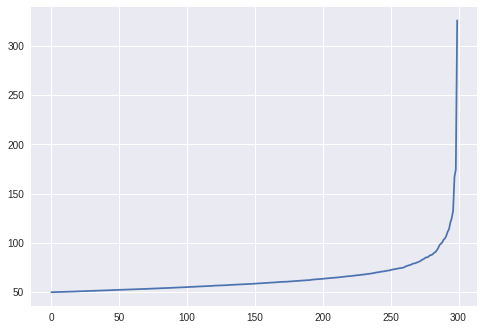

In [30]:
import matplotlib.pyplot as plt

plt.plot(ss)

In [0]:
def edge_sim(word, sim_words, word_vecs):
  """Calculate topn most similar words to word"""
  indx = tok2indx[word]
  w = word_vecs[indx:indx+1,:].flatten()
  sim = []
  for i in range(len(sim_words)):
    idx = tok2indx[sim_words[i]]
    v1 = word_vecs[idx:idx+1,:].flatten()
    p = np.dot(w, v1)/(np.linalg.norm(w)*np.linalg.norm(v1))
    value = np.arccos(-p)
    if math.isnan(value):
      value = 0.0
    sim.append(value)
  return sim

In [0]:
row_indx = []
col_indx = []
scores = []

ii = 0
for tok1, sg_count in unigram_counts.items():
    ii += 1
    if ii % 100000 == 0:
        print(f'finished {ii/len(skipgram_counts):.2%} of skipgrams')
    tok1_indx = tok2indx[tok1]

    word_scores  = ww_sim(tok1, word_vecs_norm, 8)
    words = [x[0] for x in word_scores]
    weights = edge_sim(tok1, words, word_vecs_norm)
    i = 0
    for sim_word, sim_score in word_scores:
      row_indx.append(tok1_indx)
      col_indx.append(tok2indx[sim_word])
      scores.append(weights[i])
      i = i+1

weighted_mat = sparse.csr_matrix((scores, (row_indx, col_indx)))

print('done')

In [0]:
#pre processing: remove months

In [34]:
weighted_mat.toarray().shape

(3907, 3907)

In [0]:
def transition_matrix(L):
  Dinv = np.diag([ (1. / np.sqrt(L[i].sum()) )if L[i].sum() > 0 else 0 for i in range(L.shape[0])])
  T = Dinv.dot(L).dot(Dinv)
  return T

In [0]:
POSITIVE_FINANCE = ["successful", "excellent", "profit", "beneficial", "rise", "improve", "success", "gains", "positive", "increase"]
NEGATIVE_FINANCE = ["negligent", "loss", "volatile", "wrong", "losses", "damages", "bad", "litigation", "failure", "down", "negative", "decrease"]

In [0]:
def teleport_set(words, seeds):
    return [i for i, w in enumerate(words) if w in seeds]

def weighted_teleport_set(words, seed_weights):
    return np.array([seed_weights[word] if word in seed_weights else 0.0 for word in words])

def run_iterative(M, r, update_seeds, max_iter=50, epsilon=1e-6, **kwargs):
    for i in range(max_iter):
        last_r = np.array(r)
        r = np.dot(M, r)
        update_seeds(r)
        if np.abs(r - last_r).sum() < epsilon:
            print('converged')
            break
    return r

def random_walk(embeddings, positive_seeds, negative_seeds, beta=0.9, **kwargs):
    """
    Learns polarity scores via random walks with teleporation to seed sets.
    Main method used in paper. 
    """
    def run_random_walk(M, teleport, beta, **kwargs):
        def update_seeds(r):
            r += (1 - beta) * teleport / np.sum(teleport)
        return run_iterative(M * beta, np.ones(M.shape[1]) / M.shape[1], update_seeds, **kwargs)

    if not type(positive_seeds) is dict:
        positive_seeds = {word:1/300 for word in positive_seeds}
        negative_seeds = {word:1/300 for word in negative_seeds}
    words = [indx2tok[w] for w in range(weighted_mat.toarray().shape[0])]
    M = transition_matrix(embeddings, **kwargs)
    rpos = run_random_walk(M, weighted_teleport_set(words, positive_seeds), beta, **kwargs)
    rneg = run_random_walk(M, weighted_teleport_set(words, negative_seeds), beta, **kwargs)
    return {w: rpos[i] / (rpos[i] + rneg[i]) for i, w in enumerate(words)}

In [0]:
p = random_walk(weighted_mat.toarray(), POSITIVE_FINANCE, NEGATIVE_FINANCE)

In [0]:
polarity_scores = pd.DataFrame.from_dict(p, orient='index')

In [0]:
polarity_scores.head()
polarity_scores.columns = ['scores']

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
value_standardised = scaler.fit_transform(polarity_scores['scores'].reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


In [0]:
polarity_scores['polarity_score'] = value_standardised 

In [43]:
polarity_scores.loc['rise']

scores            0.787318
polarity_score    0.601873
Name: rise, dtype: float64

In [0]:
polarity_scores.to_csv('lexicon_pos.csv', sep=",", encoding='utf-8')

In [54]:
polarity_scores.iloc[10:20, 0]

stable       0.804975
monetary     0.817317
financial    0.742415
system       0.764929
open         0.830034
market       0.740581
committee    0.860088
policy       0.801888
principle    0.781501
practice     0.934090
Name: scores, dtype: float64